In [1]:
import sys, os
import numpy as np
import time, h5py
codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import default_paths, coco_utils, nsd_utils, numpy_utils 
from utils import stats_utils, segmentation_utils, prf_utils, texture_utils
from model_fitting import initialize_fitting 
from feature_extraction import texture_statistics_pyramid
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import argparse
import pandas as pd
from skimage import io
import copy

from matplotlib import pyplot as plt
import PIL

Initializing coco api...
loading annotations into memory...
Done (t=0.62s)
creating index...
index created!
loading annotations into memory...
Done (t=16.35s)
creating index...
index created!
Initializing coco api...
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=13.69s)
creating index...
index created!


In [2]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)    

prf_ind = 697
# prf_ind = 215
# prf_ind = 831
# prf_ind = 512

prf_params = models[prf_ind,:]    
x,y,sigma = prf_params
n_pix = 425
aperture=1.0
prf = prf_utils.make_gaussian_mass(x, y, sigma, n_pix, size=aperture, \
                                      dtype=np.float32)[2]
n_prf_sd_out = 2
prf_bbox = texture_utils.get_bbox_from_prf(prf_params, (n_pix, n_pix), n_prf_sd_out, \
                                                   min_pix=None, verbose=False, force_square=False)

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [3]:
np.where((np.round(models[:,0],2)==0.0) & ((np.round(models[:,1],2)==0.0)))

(array([512, 685, 866]),)

In [106]:
models[831]

array([0.11      , 0.11      , 0.14910375])

In [108]:
# Reading some general proportions of labels out of the csv files for each pRF

subject = 1
n_columns = 93
n_prfs = len(models)

prop_annot = np.zeros((n_prfs))
prop_each = np.zeros((n_prfs, n_columns))
prop_each_of_annot = np.zeros((n_prfs, n_columns))
prop_animate = np.zeros((n_prfs))
prop_animate_of_annot = np.zeros((n_prfs))
dprime_val_animate = np.zeros((n_prfs))

for prf_model_index in range(n_prfs):
    coco_labels_fn = os.path.join(default_paths.stim_labels_root, 'S%d_within_prf'%subject, \
                                              'S%d_cocolabs_binary_prf%d.csv'%(subject, prf_model_index))
    coco_df = pd.read_csv(coco_labels_fn, index_col=0)
    mat = np.array(coco_df)

    has_any = np.any(mat==1, axis=1)
    df_has_any = coco_df.loc[has_any]
    mat_has_any = np.array(df_has_any)
    
    prop_annot[prf_model_index] = np.mean(has_any)
    prop_each[prf_model_index,:] = np.mean(mat==1, axis=0)
    prop_each_of_annot[prf_model_index,:] = np.mean(mat_has_any==1, axis=0)
    prop_animate[prf_model_index] = np.mean(np.array(coco_df['has_animate'])==1)
    prop_animate_of_annot[prf_model_index] = np.mean(np.array(df_has_any['has_animate'])==1)
    

In [129]:
names = list(coco_df.keys())
names[0:12]

['accessory',
 'animal',
 'appliance',
 'electronic',
 'food',
 'furniture',
 'indoor',
 'kitchen',
 'outdoor',
 'person',
 'sports',
 'vehicle']

In [143]:
supcat_labels = np.array(coco_df)[:,0:12]
labels = [np.where(supcat_labels[ii,:])[0] for ii in range(supcat_labels.shape[0])]
labels = np.array([ll[0] if len(ll)>0 else -1 for ll in labels])
labels.shape

(10000,)

In [145]:
np.sum(labels==0)

918

In [135]:
b

array([0, 4, 9, ..., 5, 7, 9])

Text(0.5, 1.0, 'marker size = eccentricity')

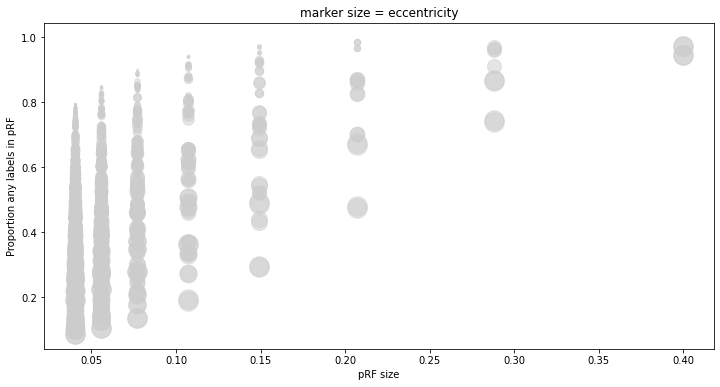

In [81]:
from matplotlib import cm
plt.figure(figsize=(12,6));
colors = cm.plasma(np.linspace(0,1,100))

for mm in range(n_prfs):

    eccen = np.sqrt(models[mm,0]**2 + models[mm,1]**2)
    s = round(eccen*50)
    plt.plot(models[mm,2], prop_annot[mm],'.',markersize=s,color=[0.8, 0.8, 0.8, 0.5])

plt.xlabel('pRF size');
plt.ylabel('Proportion any labels in pRF');
# plt.axis('square')
plt.title('marker size = eccentricity')

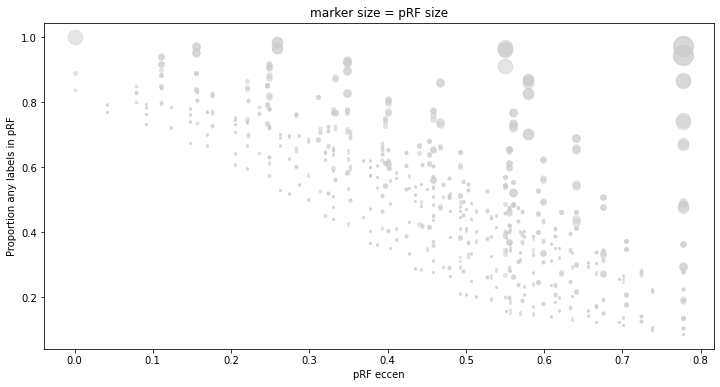

In [85]:
from matplotlib import cm
plt.figure(figsize=(12,6));
colors = cm.plasma(np.linspace(0,1,100))

for mm in range(n_prfs):
    eccen = np.sqrt(models[mm,0]**2 + models[mm,1]**2)
    s = np.round(models[mm,2]*100)
    plt.plot(eccen, prop_annot[mm],'.',markersize=s,color=[0.8, 0.8, 0.8, 0.5])

plt.xlabel('pRF eccen');
plt.ylabel('Proportion any labels in pRF');
# plt.axis('square')
plt.title('marker size = pRF size');

Text(0, 0.5, 'pRF y pos')

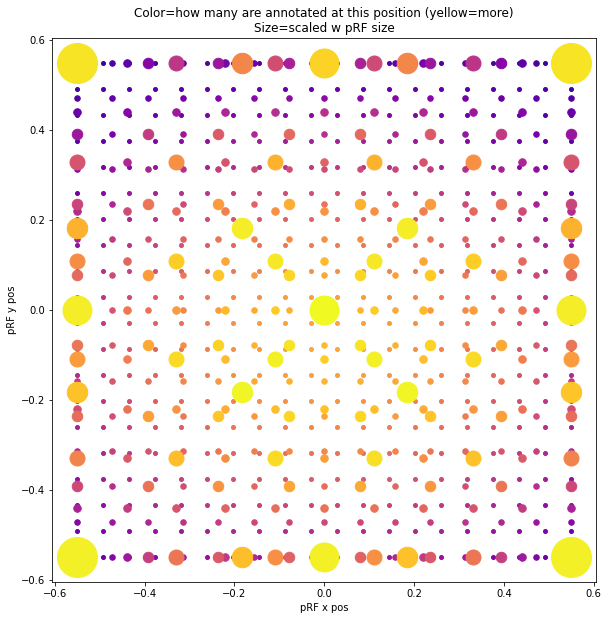

In [109]:
from matplotlib import cm
plt.figure(figsize=(10,10));
colors = cm.plasma(np.linspace(0,1,100))

for mm in range(n_prfs):
# for mm in range(10):
    
    s = round(models[mm,2]*200)
#     s = round(prop_annot[mm]*100)
    c = colors[int(prop_annot[mm]*100),:]
#     print(s)
    plt.plot(models[mm,0], models[mm,1], '.', color=c, markersize=s)

plt.axis('square');
plt.title('Color=how many are annotated at this position (yellow=more)\nSize=scaled w pRF size');
plt.xlabel('pRF x pos')
plt.ylabel('pRF y pos')

Text(0, 0.5, 'pRF y pos')

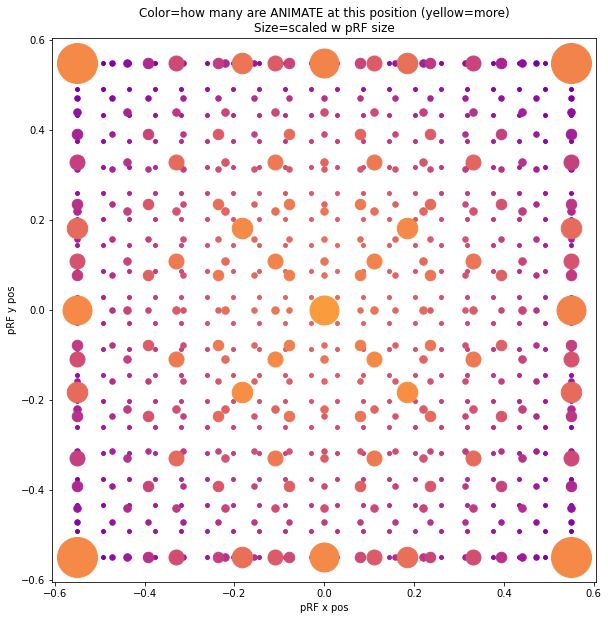

In [127]:
from matplotlib import cm
plt.figure(figsize=(10,10));
colors = cm.plasma(np.linspace(-0.3,1.3,100))

for mm in range(n_prfs):
# for mm in range(10):
    
    s = round(models[mm,2]*200)
#     s = round(prop_annot[mm]*100)
    c = colors[int(prop_animate_of_annot[mm]*100),:]
#     print(s)
    plt.plot(models[mm,0], models[mm,1], '.', color=c, markersize=s)

plt.axis('square');
plt.title('Color=how many are ANIMATE at this position (yellow=more)\nSize=scaled w pRF size');
plt.xlabel('pRF x pos')
plt.ylabel('pRF y pos')

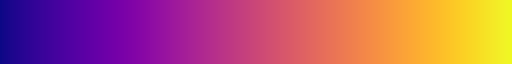

In [53]:
cm.plasma